# Boundary vector score (BVS) - workflow and tests

Implementation of Debora's boundary vector score script in python

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set up basics
import sys, os
import numpy as np 
from collections import OrderedDict
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

import datajoint as dj

In [3]:
# Load base schema
schema = dj.schema(dj.config['dj_imaging.database'])
schema.spawn_missing_classes()

Connecting horsto@kavlidatajoint02.it.ntnu.no:3306


### Load an example ... 

In [220]:
current_session = "218598b321b72d27"
session_key = Session.proj() & f'session_name = "{current_session}"'

cell_param_dict = OrderedDict([('ang_params_id', 'A'),
                             ('border_params_id', 'A'),
                             ('channel', 'primary'),
                             ('field_params_id', 'A'),
                             ('grid_params_id', 'A'),
                             ('map_params_id', 'A'),
                             ('noise_calc_id', 'A'),
                             ('s_t_params_id', 'A'),
                             ('shuffle_params_id', 'A'),
                             ('signal_type', 'spikes'),
                             ('spike_filter_id', 'A'),
                             ('trackingparams_id', 'A')])

In [221]:
some_ratemaps = Ratemap & session_key & cell_param_dict

In [222]:
cell =1 # 80
ratemap_entry = (some_ratemaps & f'cell_id = {cell}').fetch1()

In [223]:
rm      = np.ma.array(ratemap_entry['ratemap'], mask = ratemap_entry['mask_rm'])
rm_nans = np.ma.filled(rm, fill_value=np.nan).astype(np.float64)

In [224]:
rm_nans.shape

(32, 32)

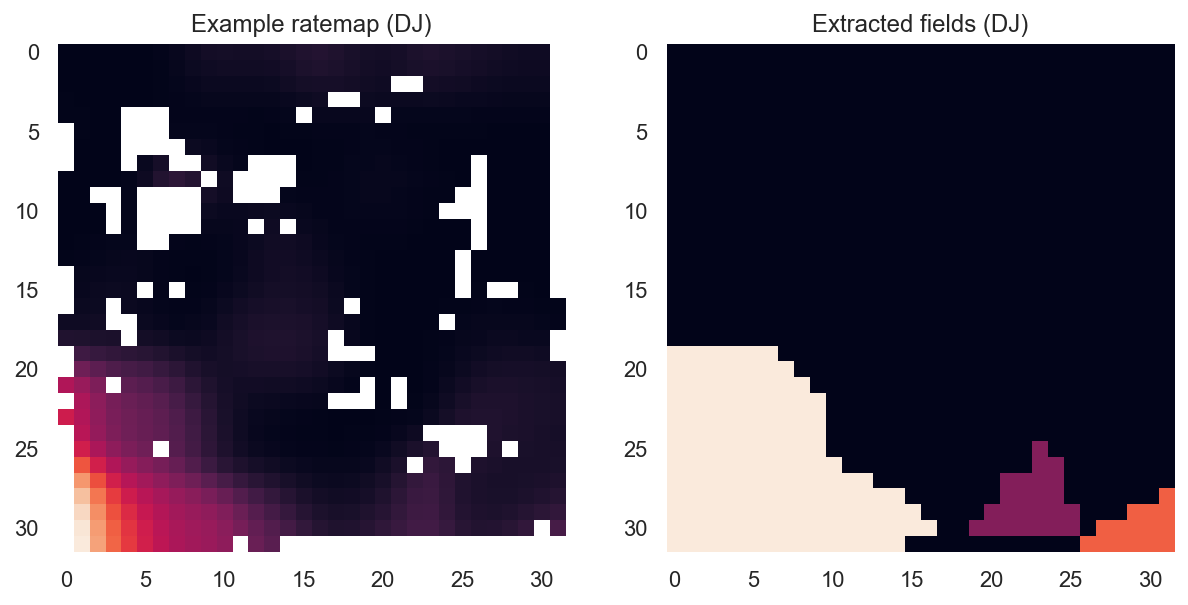

In [225]:
figure = plt.figure(figsize=(10,5))
ax = figure.add_subplot(121)
ax.imshow(rm_nans)
ax.set_title('Example ratemap (DJ)')
ax = figure.add_subplot(122)
ax.imshow(ratemap_entry['fields_map'])
ax.set_title('Extracted fields (DJ)')
sns.despine(left=True,bottom=True)

### Functions

In [226]:
from bvs.bv_score import calc_bv_score
from bvs.detect_fields import detect_fields

Thresholds
----------
fieldDetectionThresh: 153.00451162304807
fieldInclusionThresh: 279.1134029616641
minBin: 16

Fields
------
Detected 3 fields
Maxima of detected regions:   [898.67996527 157.66179446 165.14569279]
Length of detected regions:   [108   2   1]
1 fields remain



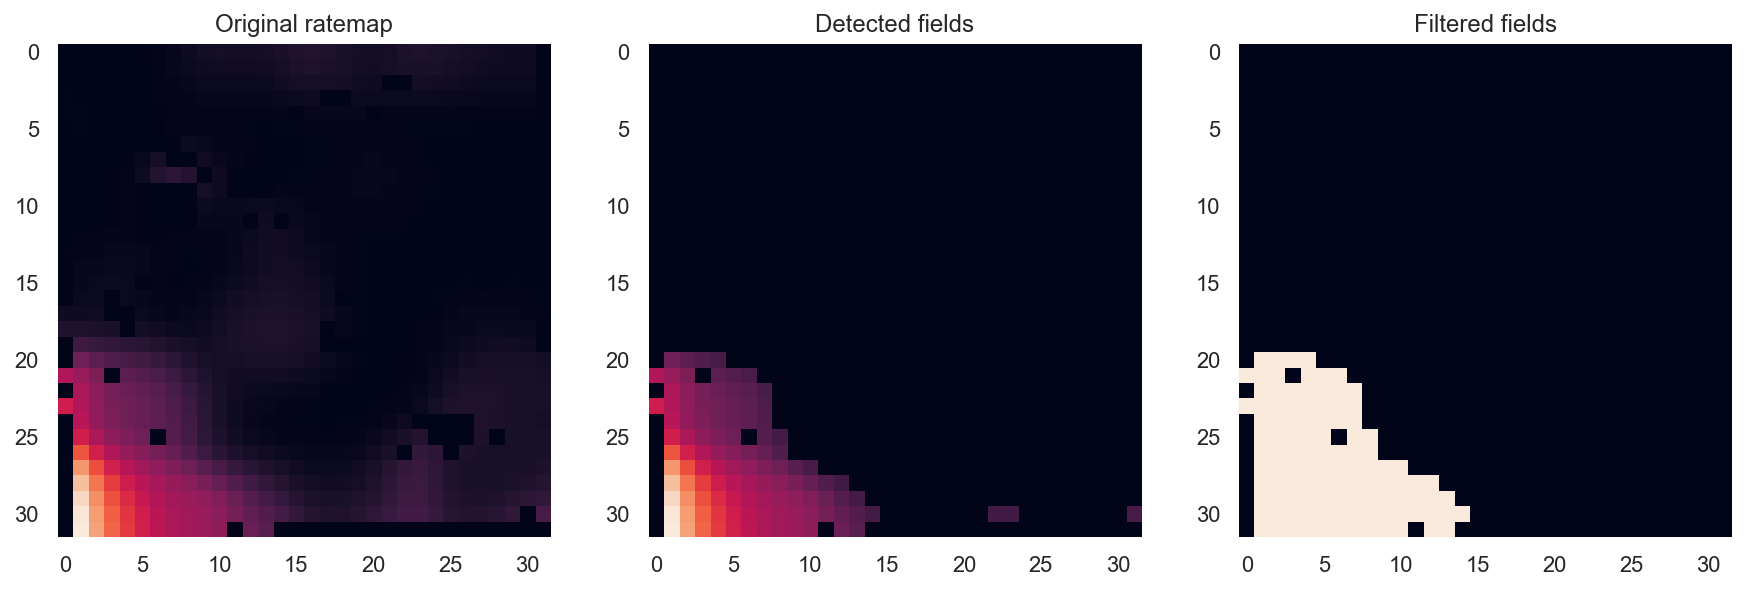

In [227]:
fieldmap, remaining_fields = detect_fields(rm_nans, minBin=16, show_plots=True, debug=True)

Barwidth ranges:  [1 2 3 4 5]
r value: 0.5
Looping over horizontal bars ... 
Score increased to -0.071 | yPos: 0 (barwidth: 1)
Score increased to  0.058 | yPos: 20 (barwidth: 1)
Score increased to  0.123 | yPos: 21 (barwidth: 1)
Score increased to  0.155 | yPos: 22 (barwidth: 1)
Score increased to  0.188 | yPos: 23 (barwidth: 1)
Score increased to  0.252 | yPos: 27 (barwidth: 1)
Score increased to  0.317 | yPos: 28 (barwidth: 1)
Score increased to  0.349 | yPos: 29 (barwidth: 1)
Score increased to  0.381 | yPos: 30 (barwidth: 1)

Looping over vertical bars ... 
Score increased to -0.006 | xPos: 0 (barwidth: 1)
Score increased to  0.317 | xPos: 1 (barwidth: 1)

Final boundary vector score: 0.3810483870967742 (horizontal)


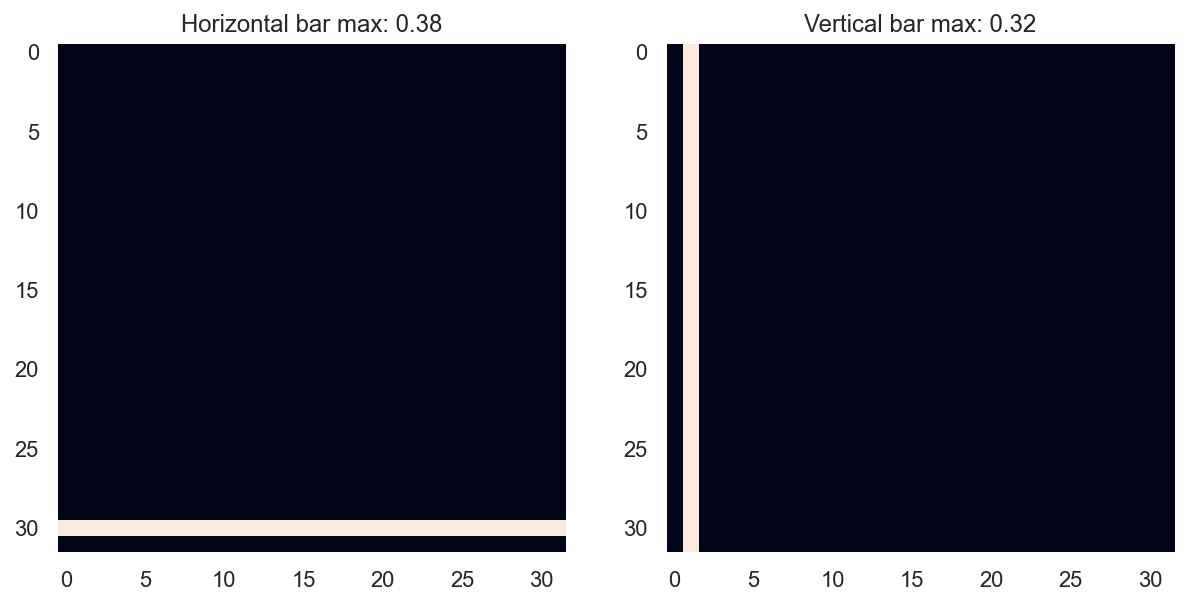

In [229]:
bvs, bvs_x, bvs_y, max_orientation = calc_bv_score(fieldmap, r=.5, barwidth_max=5, show_plots=True, debug=True)

In [230]:
bvs # max of x and y 

0.3810483870967742

### Save for matlab

In [231]:
from scipy.io import savemat

In [232]:
rm_dict = {'map': rm_nans, 
           'dj_session_name': current_session, 
           'dj_cell_id': cell, 
           'dj_cell_param_dict': cell_param_dict, 
           'xScore_python' : bvs_x['score_x'],
           'yScore_python' : bvs_y['score_y']}
savemat(f'matlab/test_data/cell_{cell}_{current_session}.mat',rm_dict)
print(f'Saved under \nmatlab/test_data/cell_{cell}_{current_session}.mat')

Saved under 
matlab/test_data/cell_1_218598b321b72d27.mat


### Run bvs calculation over opexebo field map

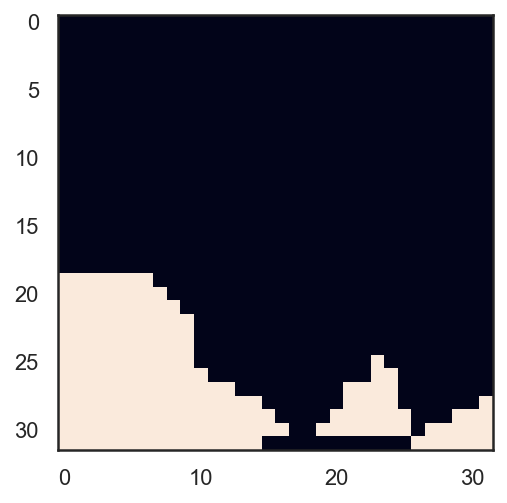

In [233]:
fieldmap_opex = ratemap_entry['fields_map'].copy()
fieldmap_opex[fieldmap_opex>0] = 1
plt.imshow(fieldmap_opex)

Barwidth ranges:  [1 2 3 4 5]
r value: 0.5
Looping over horizontal bars ... 
Score increased to -0.112 | yPos: 0 (barwidth: 1)
Score increased to  0.114 | yPos: 19 (barwidth: 1)
Score increased to  0.146 | yPos: 20 (barwidth: 1)
Score increased to  0.178 | yPos: 21 (barwidth: 1)
Score increased to  0.211 | yPos: 22 (barwidth: 1)
Score increased to  0.243 | yPos: 25 (barwidth: 1)
Score increased to  0.307 | yPos: 26 (barwidth: 1)
Score increased to  0.436 | yPos: 27 (barwidth: 1)
Score increased to  0.533 | yPos: 28 (barwidth: 1)
Score increased to  0.695 | yPos: 29 (barwidth: 1)
Score increased to  0.824 | yPos: 30 (barwidth: 1)

Looping over vertical bars ... 
Score increased to  0.307 | xPos: 0 (barwidth: 1)

Final boundary vector score: 0.8235887096774194 (horizontal)


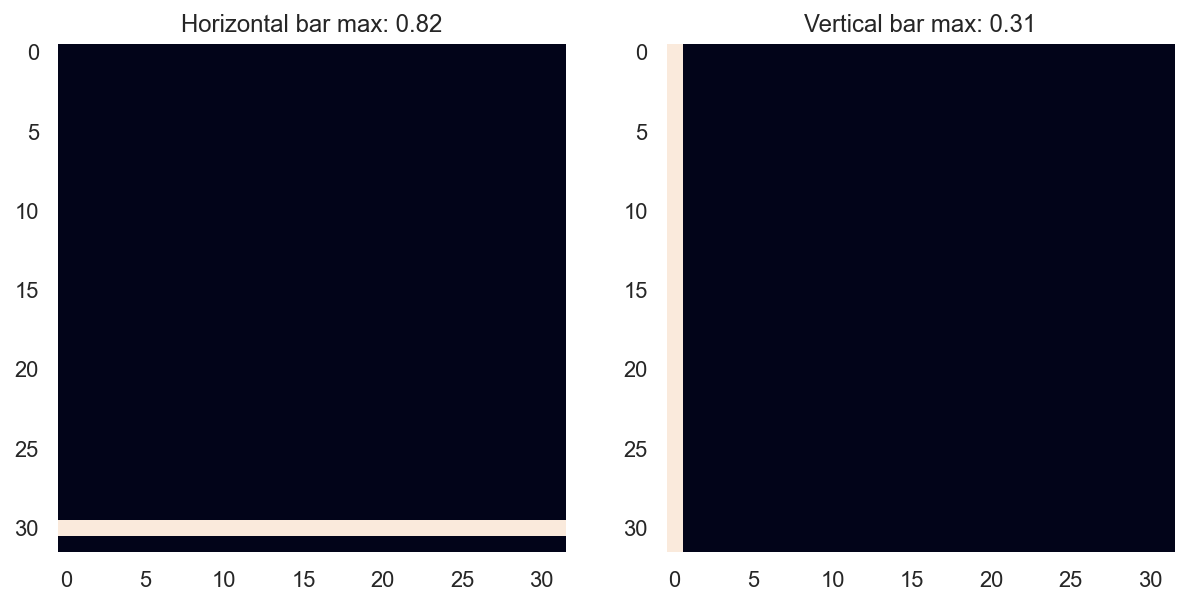

In [234]:
bvs, bvs_x, bvs_y, max_orientation = calc_bv_score(fieldmap_opex, r=.5, barwidth_max=5, show_plots=True, debug=True)

In [235]:
bvs_x

{'score_x': 0.8235887096774194,
 'bar_width': 1,
 'ypos': 30.5,
 'ypos_rel': 0.953125,
 'bar_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]])}